In [28]:
# Importing the necessary packages
import numpy as np                                  # "Scientific computing"
import scipy.stats as stats                         # Statistical tests

import pandas as pd                                 # Data Frame
from pandas.api.types import CategoricalDtype

import matplotlib.pyplot as plt                     # Basic visualisation
import seaborn as sns                               # Advanced data visualisation
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

In [29]:
penguins = pd.read_csv('https://raw.githubusercontent.com/jdecorte/machinelearning/main/datasets/penguins.csv')
penguins.head()

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
0,39.1,18.7,181.0,3750.0,0
1,39.5,17.4,186.0,3800.0,0
2,40.3,18.0,195.0,3250.0,0
3,NaN,NaN,NaN,NaN,0
4,36.7,19.3,193.0,3450.0,0


Er zijn nog null-waarden in de dataset. Deze halen we eruit.

In [30]:
penguins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CulmenLength   342 non-null    float64
 1   CulmenDepth    342 non-null    float64
 2   FlipperLength  342 non-null    float64
 3   BodyMass       342 non-null    float64
 4   Species        344 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 13.6 KB


In [31]:
penguins = penguins.dropna()

Welke variabelen zijn van het datatype 'float'?

In [32]:
penguin_features = penguins.select_dtypes(include=['float64']).columns

Welke klassen kunnen een pinguïn mogelijk toebehoren?

In [33]:
penguin_classes = penguins.Species.unique()

Gebruik een zo efficiënt mogelijke manier om een boxplot te tonen voor iedere feature. Iedere feature moet gegroepeerd zijn op basis van species. In principe moet je per plot telkens drie subplots zien.

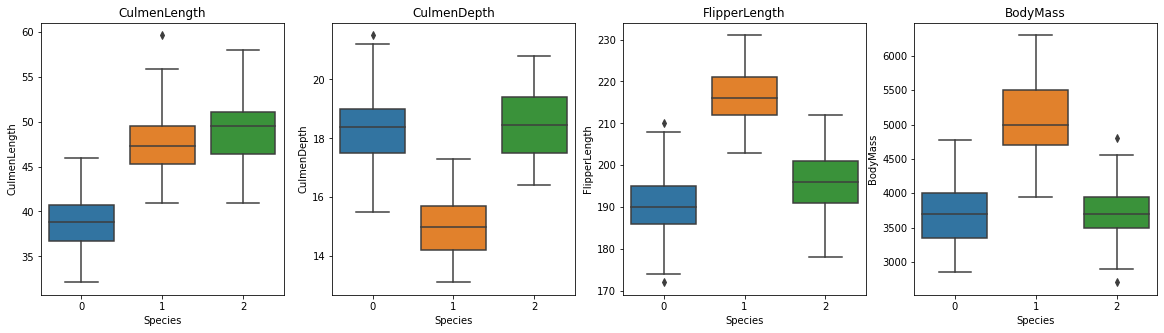

In [34]:
fig, axs = plt.subplots(1, len(penguin_features), figsize=(20, 5))

for i in range(0, len(penguin_features)):
  sns.boxplot(ax=axs[i], data = penguins, y = penguin_features[i], x='Species')
  axs[i].set_title(penguin_features[i])

<AxesSubplot:xlabel='BodyMass', ylabel='CulmenLength'>

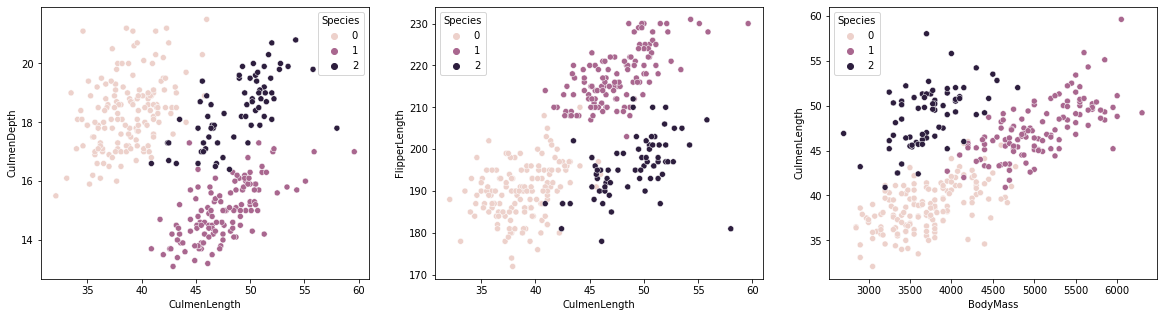

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

sns.scatterplot(ax=axs[0], data = penguins, x = 'CulmenLength', y = 'CulmenDepth', hue='Species')
sns.scatterplot(ax=axs[1], data = penguins, x = 'CulmenLength', y = 'FlipperLength', hue='Species')
sns.scatterplot(ax=axs[2], data = penguins, x = 'BodyMass', y = 'CulmenLength', hue='Species')

## Model maken

1. We wijzen de X en y variabele toe aan de variabele die we willen voorspellen. In dit geval willen wij het geslacht van een pinguïn gaan voorspellen.
2. We splitsen de dataset in een training- en testset.
3. We werken met een GridSearch om de beste parameters te vinden voor een model van DecisionTree.

In [36]:
X = penguins.drop("Species", axis = 1)
y = penguins['Species']  

In [37]:
from sklearn.model_selection import train_test_split    
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)  

In [38]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'criterion': ["gini", "entropy"],
    'max_depth': [1,2,3,4,5,6,7,8,9],
    'min_samples_split': (0.05,0.1, 0.2, 0.3,0.4),
    'min_samples_leaf': (0.05,0.1,0.2, 0.3,0.4)
}

In [39]:
grid_clf = GridSearchCV(DecisionTreeClassifier(random_state = 42), param_grid, scoring='accuracy', cv=3)

grid_clf.fit(X_train,y_train)

# best estimator
print(f"best estimator = {grid_clf.best_estimator_}")
# best score
print(f"best score = {grid_clf.best_score_}")

best estimator = DecisionTreeClassifier(max_depth=2, min_samples_leaf=0.2,
                       min_samples_split=0.05, random_state=42)
best score = 0.9531235750114


## Evaluatie van het model

Er zijn twee manieren om het model te evalueren:
1. Accuracy-score berekenen
2. Confusion matrix opzetten (vooral voor classificatie)
3. Vanuit de confusion matrix de precision en recall berekenen. We zitten met een multiclass confusion matrix, dus moeten we de extra optie average meegeven.
4. Predict_proba gaan we gebruiken om de nauwkeurigheid van een voorspelling te gaan bijhouden per label. We willen de pinguïns zien waar er een verkeerde klasse aan werd toegewezen.

In [27]:
from sklearn.metrics import accuracy_score

best_model = grid_clf.best_estimator_
best_model.fit(X_train,y_train)

y_pred = best_model.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.8953488372093024


Text(91.68, 0.5, 'Actual class')

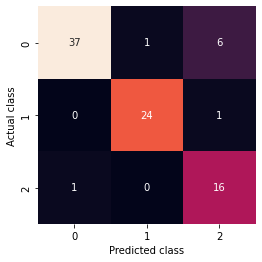

In [41]:
from sklearn.metrics import confusion_matrix
conf_mx = confusion_matrix(y_test, y_pred)
cf = sns.heatmap(conf_mx,square=True, annot=True, fmt='d', cbar=False, xticklabels=penguin_classes, yticklabels=penguin_classes)
cf.set_xlabel('Predicted class')
cf.set_ylabel('Actual class')

In [46]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(grid_clf, X_train, y_train, cv=3)

from sklearn.metrics import precision_score, recall_score
print(f"The precision is: {precision_score(y_train, y_train_pred, average='macro')}")
print(f"The recall is: {recall_score(y_train, y_train_pred, average='macro')}")

The precision is: 0.9391359578354367
The recall is: 0.9253140508539864


In [48]:
y_scores = grid_clf.predict_proba(X_test)

for ((index, correct), scores) in zip(y_test.items(), y_scores):
  if correct != np.argmax(scores):
    print(f"index = {index}\tcorrect = {correct}   predicted = {np.argmax(scores)}   scores = {scores}")

index = 43	correct = 0   predicted = 2   scores = [0.09433962 0.01886792 0.88679245]
index = 109	correct = 0   predicted = 2   scores = [0.09433962 0.01886792 0.88679245]
index = 111	correct = 0   predicted = 2   scores = [0.09433962 0.01886792 0.88679245]
index = 184	correct = 1   predicted = 2   scores = [0.09433962 0.01886792 0.88679245]
index = 73	correct = 0   predicted = 2   scores = [0.09433962 0.01886792 0.88679245]
index = 17	correct = 0   predicted = 2   scores = [0.09433962 0.01886792 0.88679245]
index = 115	correct = 0   predicted = 2   scores = [0.09433962 0.01886792 0.88679245]
index = 306	correct = 2   predicted = 0   scores = [1. 0. 0.]
index = 95	correct = 0   predicted = 1   scores = [0.00980392 0.95098039 0.03921569]
